# Machine Learning II 2023-2024 - UMONS
# Variational autoencoders

In this lab, we will implement variational autoencoders.

The plan of the lab is as follows:
1. The `Distribution` objects are introduced. This will allow us to conveniently work with distributions in PyTorch.
2. We implement the encoder and decoder of the variational autoencoder.
3. We implement the loss of the variational autoencoder.
4. Optional experiments are provided at the end, for those that are interested.

The parts that have to be completed are indicated using `TODO`.

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

## PyTorch distributions

Many `Distribution` objects are available in [PyTorch](https://pytorch.org/docs/stable/distributions.html).
In this short tutorial, we will explore the `Normal` distribution and how shapes of `Distribution` objects are handled.

Mean: 0.0, standard deviation: 1.0


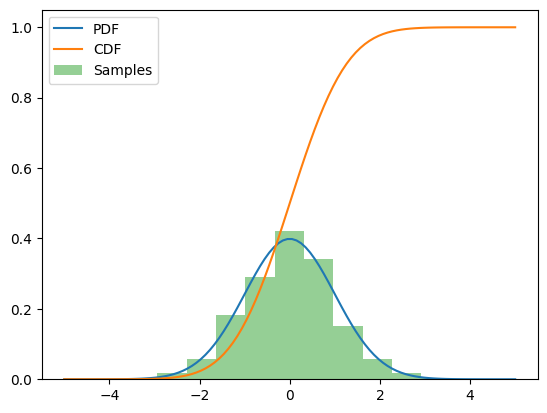

In [ ]:
# We create a normal distribution with mean 0 and standard deviation 1.
dist = D.Normal(0, 1)
print(f'Mean: {dist.loc}, standard deviation: {dist.scale}')

fig, axis = plt.subplots()
x = torch.linspace(-5, 5, 100)
# We plot the probability density function (PDF) using the `log_prob` method.
axis.plot(x, dist.log_prob(x).exp(), label='PDF')
# We plot the cumulative density function (CDF) using the `cdf` method.
axis.plot(x, dist.cdf(x), label='CDF')
# We plot a histogram of 1000 samples from the distribution.
axis.hist(dist.sample((1000,)), density=True, alpha=0.5, label='Samples')
axis.legend()

While PyTorch `Tensor` objects have a single `.shape`, `Distribution` objects have two shape attributes that are semantically different:
- `event_shape`: The shape of a single event from the distribution.
- `batch_shape`: The shape of a single sample from one or more distribution of the same family. As an example, we can’t have a batch of a normal and Gamma distribution together, but we can have a batch of more than one normal distributions with different means and standard deviations.

Additionally, a `sample_shape` argument can be given when sampling from `Distribution` objects.

In [ ]:
# We create 3 normal distributions with means -2, 0 and 2, and standard deviation 1.
dist = D.Normal(torch.tensor([-2., 0., 2.]), torch.ones(3))
# By default, `Normal` distributions have an empty `event_shape` because they are univariate.
assert dist.batch_shape == (3,) and dist.event_shape == ()
# The shape of a sample is `sample_shape + batch_shape + event_shape`.
sample_shape = (2,)
assert dist.sample(sample_shape).shape == (2, 3)
# The shape returned by `log_prob` is `sample_shape + batch_shape`.
assert dist.log_prob(torch.zeros(3)).shape == (3,)

To represent multivariate normal distributions with a diagonal covariance, we can use the `Independent` class.

In [ ]:
dist = D.Normal(torch.tensor([-2., 0., 2.]), torch.ones(3))
# The last dimension of the `batch_shape` is reinterpreted as the `event_shape`.
dist = D.Independent(dist, 1)
assert dist.batch_shape == () and dist.event_shape == (3,)
# Samples keep the same dimension than before.
sample_shape = (2,)
assert dist.sample(sample_shape).shape == (2, 3)
# The shape returned by `log_prob` is different because we compute the log PDF of a single multivariate distribution.
assert dist.log_prob(torch.zeros(3)).shape == ()

In [ ]:
# TODO: Create a `Normal` distribution with a `batch_shape` of `(4, 5)` and an `event_shape` of `(3,)`.
# Fix the means and standard deviations at 0 and 1.
# Then, sample from this distribution with a `sample_shape` of `(2,)`.
# What is the shape of the sampled event?
dist = D.Normal(torch.zeros(4, 5, 3), torch.ones(4, 5, 3))
dist = D.Independent(dist, 1)
assert dist.batch_shape == (4, 5) and dist.event_shape == (3,)
assert dist.sample((2,)).shape == (2, 4, 5, 3)

## Constants and hyperparameters of the VAE

In [ ]:
height, width = 28, 28
X_dim = height * width
Z_dim = 64
H_dim = 128

num_epochs = 8
batch_size = 128
device = 'cpu'

## Load and plot the dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
     # We normalize the data to have zero mean and unit standard deviation using precomputed values.
    transforms.Normalize((0.1307,), (0.3081,)),
     # We simplify the problem by transforming the gray images to binary images.
    lambda x: x > 0,
])
train_data = MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 35899312.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37985479.41it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8476489.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16829089.02it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



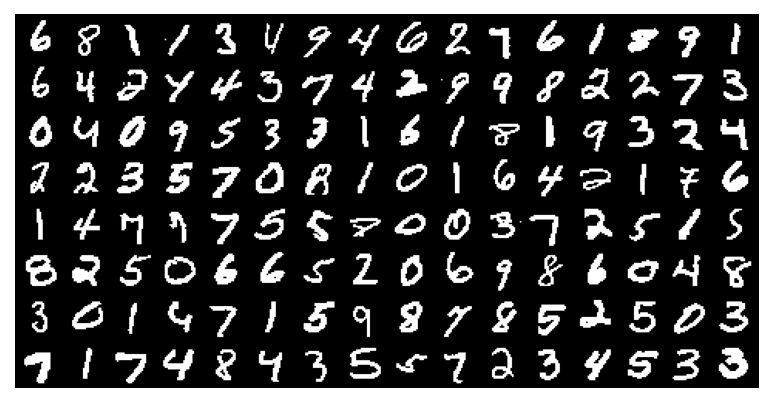

In [ ]:
def plot_images(images):
    grid = torchvision.utils.make_grid(images, nrow=16)
    fig, axis = plt.subplots(dpi=150)
    axis.imshow(grid[0], cmap='gray')
    axis.axis('off')
    plt.show()

first_batch = next(iter(train_loader))[0]
plot_images(first_batch.float())

## Encoder and decoder

In [ ]:
# The encoder generates a distribution over the latent space from image samples.
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: implement the encoder model.
        # It should be similar to the decoder model except that the last layers are different.
        # The output dimension should be two times the latent dimension (Z_dim) because
        # we need both the mean and the variance of the distribution.
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 2 * Z_dim),
        )

    def forward(self, x):
        # We scale the values to the [-1, 1] interval.
        x = (x - 0.5) * 2
        # We split the output into two parts of equal size.
        mu, rho = torch.chunk(self.model(x), 2, dim=1)
        # TODO: Firstly, ensure that the standard deviation is positive using the `F.softplus` function.
        std = F.softplus(rho)
        # TODO: Secondly, create a distribution over the latent space using the `Normal` and `Independent` classes.
        # The returned distribution should be a multivariate normal of dimension `Z_dim` with diagonal covariance matrix.
        return D.Independent(D.Normal(mu, std), 1)


# The decoder generates a distribution over binary images from latent samples.
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # At the last layers, we have to use `nn.Sigmoid` to ensure that the output is
        # a valid probability.
        # Then, we use `nn.Unflatten` to reshape the output to the correct image size.
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, height, width)),
        )

    def forward(self, z):
        probs = self.model(z)
        return D.Independent(D.Bernoulli(probs), 3)

## VAE training

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

prior = D.Independent(D.Normal(torch.zeros(Z_dim).to(device), torch.ones(Z_dim).to(device)), 1)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
step = 0
for epoch in range(num_epochs):
    for x, _ in train_loader:
        x = x.to(device).float()
        # ===== Forward pass =====
        z_dist = encoder(x)
        # TODO: Sample `z` using the reparameterization trick based on `z_dist.base_dist.loc` and `z_dist.base_dist.scale`.
        # Alternatively, use `z_dist.rsample()`, which already implements the reparameterization trick.
        z = z_dist.rsample()
        #z = torch.randn(z_dist.batch_shape + z_dist.event_shape).to(device) * z_dist.base_dist.scale + z_dist.base_dist.loc
        x_dist = decoder(z)
        # ===== Loss =====
        # TODO: Compute the reconstruction loss, the regularization, and the total loss.
        # For the reconstruction loss, use the `log_prob` method of `x_dist`.
        # For the regularization, use the `D.kl_divergence` function, which allows to compute the KL divergence
        # between two normal distributions.
        reconstruction_loss = -x_dist.log_prob(x).mean()
        complexity_loss = D.kl_divergence(z_dist, prior).mean()
        loss = reconstruction_loss + complexity_loss
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===== Logging =====
        if step % 100 == 0:
            print(f'epoch [{epoch + 1}/{num_epochs}], step {step + 1}, loss:{loss.item():.4f}')
        step += 1

epoch [1/8], step 1, loss:552.6284
epoch [1/8], step 101, loss:222.3386
epoch [1/8], step 201, loss:212.5415
epoch [1/8], step 301, loss:202.4470
epoch [1/8], step 401, loss:178.3376
epoch [2/8], step 501, loss:173.2103
epoch [2/8], step 601, loss:158.8553
epoch [2/8], step 701, loss:162.2328
epoch [2/8], step 801, loss:140.4736
epoch [2/8], step 901, loss:138.6618
epoch [3/8], step 1001, loss:139.1788
epoch [3/8], step 1101, loss:140.2666
epoch [3/8], step 1201, loss:129.2148
epoch [3/8], step 1301, loss:127.0801
epoch [3/8], step 1401, loss:128.4515
epoch [4/8], step 1501, loss:126.0352
epoch [4/8], step 1601, loss:120.8254
epoch [4/8], step 1701, loss:114.3951
epoch [4/8], step 1801, loss:116.8617
epoch [5/8], step 1901, loss:116.3174
epoch [5/8], step 2001, loss:113.9973
epoch [5/8], step 2101, loss:107.9793
epoch [5/8], step 2201, loss:110.8613
epoch [5/8], step 2301, loss:112.1847
epoch [6/8], step 2401, loss:107.1616
epoch [6/8], step 2501, loss:106.1099
epoch [6/8], step 2601, 

## Sampling

Sampling is simply done by decoding a sample from the prior. The quality of samples can be improved by using a bigger model and training for more epochs.

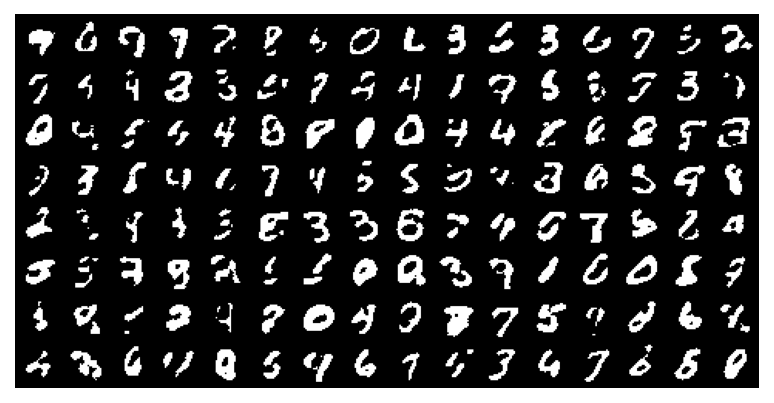

In [ ]:
z = prior.sample((batch_size,))
with torch.no_grad():
    # Instead of sampling from the Bernouilli distribution of the decoder, a common
    # approach is to take the mode of the distribution, so that images are less noisy.
    sample = decoder(z).mode
plot_images(sample.cpu())

## Interpolation

Images that are semantically similar will tend to be close to each other in the latent space.
Thus, a linear interpolation between samples in the latent space will create an interpolation
between images that are semantically similar in the image space.

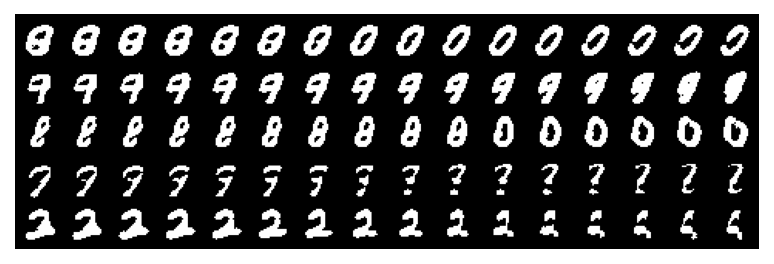

In [ ]:
z_list = []
for _ in range(5):
    z1, z2 = prior.sample(), prior.sample()
    alpha = torch.linspace(0, 1, 16)[:, None]
    z_interp = z1 * (1 - alpha) + z2 * alpha
    z_list.append(z_interp)
z = torch.cat(z_list)
with torch.no_grad():
    sample = decoder(z).mode
plot_images(sample.cpu())

# Optional experiments

## Dimensionality reduction

Dimensionaly reduction techniques such t-SNE can be costly on high dimensional data such as images.
One approach is to reduce the dimension using, e.g., a variational auto-encoder, and before applying t-SNE.

<Axes: >

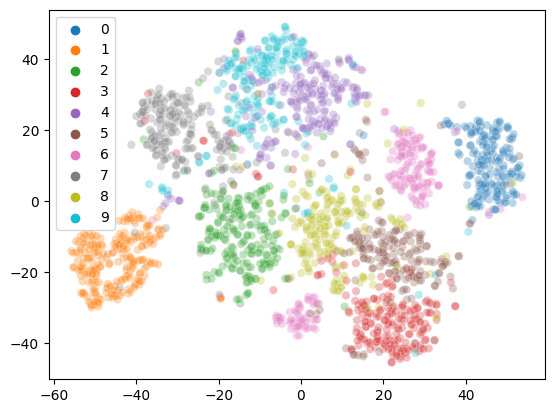

In [ ]:
test_data = MNIST('./data', train=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size)

z_list = []
y_list = []
for x, y in test_loader:
    x = x.to(device).float()
    with torch.no_grad():
        z_dist = encoder(x)
    z_list.append(z_dist.base_dist.loc)
    y_list.append(y)
z = torch.cat(z_list, dim=0)[:2000]
y = torch.cat(y_list, dim=0)[:2000]

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=0)
tsne_results = tsne.fit_transform(z.cpu())

sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=y.numpy().astype('str'),
    hue_order=[str(i) for i in range(10)],
    alpha=0.3,
)

## Convolutional variational auto-encoders

In this lab, we implemented the encoders and decoders using fully connected neural networks for simplicity.
Convolutional neural networks would be more suitable for images and would give improved results.
Feel free to run the experiments using the encoders and decoders below.
Better results could be achieved using more convolutions.

In [ ]:
base_channel_dim = 1 # The images are binary images with a single channel.
C_dim = 32 # Number of channels in the first hidden layer of the encoder.
kernel_size = 3
stride = 2
padding = 1

def conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, **kwargs):
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, **kwargs)

def conv_transpose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, **kwargs):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, **kwargs)


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            # base_channel_dim, 28, 28
            conv2d(in_channels=base_channel_dim, out_channels=C_dim),
            # C_dim, 14, 14
            nn.ReLU(),
            conv2d(in_channels=C_dim, out_channels=C_dim * 2),
            # C_dim * 2, 7, 7
            nn.ReLU(),
            conv2d(in_channels=C_dim * 2, out_channels=C_dim * 4),
            # C_dim * 4, 4, 4
            nn.ReLU(),
            nn.Flatten(),
            # C_dim * 4 * 4 * 4
            nn.Linear(C_dim * 4 * 4 * 4, H_dim),
            # H_dim
            nn.ReLU(),
            nn.Linear(H_dim, 2 * Z_dim),
            # 2 * Z_dim
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # We scale the values to the [-1, 1] interval.
        x = (x - 0.5) * 2
        mu, rho = torch.chunk(self.model(x), 2, dim=1)
        return D.Independent(D.Normal(mu, F.softplus(rho)), 1)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            # Z_dim
            nn.Linear(Z_dim, H_dim),
            # H_dim
            nn.ReLU(),
            nn.Linear(H_dim, C_dim * 4 * 4 * 4),
            # C_dim * 4 * 4 * 4
            nn.ReLU(),
            nn.Unflatten(1, (C_dim * 4, 4, 4)),
            # C_dim * 4, 4, 4
            conv_transpose2d(in_channels=C_dim * 4, out_channels=C_dim * 2),
            nn.ReLU(),
            # C_dim * 2, 7, 7
            conv_transpose2d(in_channels=C_dim * 2, out_channels=C_dim, output_padding=1),
            nn.ReLU(),
            # C_dim, 14, 14
            conv_transpose2d(in_channels=C_dim, out_channels=base_channel_dim, output_padding=1),
            # 1, 28, 28
            nn.Sigmoid(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        probs = self.model(z)
        return D.Independent(D.Bernoulli(probs), 3)